In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_30465/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
import os
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

### load main df and geolocation df

In [18]:
data_dir1 = '/home/bluerivertech/li.yu/data/all_hitchhiker_left_images_location_filtered_20220729'
df1 = pd.read_csv(os.path.join(data_dir1, 'annotations.csv'), low_memory=False)
data_dir2 = '/home/bluerivertech/li.yu/data/only_new_hitchhiker_left_images_location_filtered_20221018'
df2 = pd.read_csv(os.path.join(data_dir2, 'annotations.csv'), low_memory=False)
df = pd.concat([df1, df2], ignore_index=True)
state_df1 = pd.read_csv(os.path.join(data_dir1, 'geolocation.csv'))[['robot_name', 'date', 'state', 'county']]
state_df2 = pd.read_csv(os.path.join(data_dir2, 'geolocation.csv'))[['robot_name', 'date', 'state', 'county']]
state_df = pd.concat([state_df1, state_df2], ignore_index=True)
df.shape, state_df.shape

((2351325, 81), (772, 4))

### create sub df to get geolocation

In [51]:
# df2['date'] = df2.collected_on.str[:10]
# sub_df = df2.groupby(['robot_name', 'date']).first()
# sub_df = sub_df[['id', 'state', 'county']].merge(df2[['id', 'robot_name', 'date']], on='id')
# print(sub_df.shape)

(212, 76)


In [32]:
# import pandas as pd
# from tqdm import tqdm
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# geolocator = Nominatim(user_agent="location finder")

# # reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
# # location = reverse((50.6539239, -120.3385242), language='en', exactly_one=True)
# # print(location)

# def get_location(r):
#     if r['latitude'] == 0 and r['longitude'] == 0:
#         state, county = 'unknown', 'unknown'
#     else:
#         location = geolocator.reverse(f"{r['latitude']}, {r['longitude']}")
#     #     location = reverse((float(r['latitude']), float(r['longitude'])), language='en', exactly_one=True)
#         county = location.raw["address"]["county"]
#         state = location.raw["address"]["state"]
#     return state, county

# # def get_location(r):
# #     return 'xxxx', 'yyyy'
    
# print(sub_df.shape)
# for i,r in tqdm(sub_df.iterrows(), total=len(sub_df)):
#     state, county = get_location(r)
#     sub_df.at[i, 'state'] = state
#     sub_df.at[i, 'county'] = county
# sub_df.to_csv(os.path.join(data_dir2, 'geolocation.csv'), index=False)

(212, 76)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [01:26<00:00,  2.45it/s]

(212, 76)


In [19]:
# update state and county in df
df['date'] = df.collected_on.str[:10]
df['datetime'] = df.collected_on.apply(datetime.fromisoformat)

g = state_df.groupby(['robot_name', 'date', 'state', 'county'])
keys = g.groups.keys()
for r, d, s, c in tqdm(keys, total=len(keys)):
#     _df = state_df[(state_df.robot_name == r) & (state_df.date == d) & (state_df.county == c)]
#     if _df.shape[0] < 2:
#         print(s, c)
    df.loc[(df.robot_name == r) & (df.date == d) & (df.state == 'unknown'), "state"] = s
    df.loc[(df.robot_name == r) & (df.date == d) & (df.state == 'unknown'), "county"] = c

df['speed_ms'] = df.gps_can_data.apply(lambda a: ast.literal_eval(a).get('speed', 0))  # speed in m/s
df['speed_mph'] = df['speed_ms'] * 2.23694  # speed in mph

df['wind_speed_ms'] = df.weather_summary.apply(lambda a: ast.literal_eval(a).get('windspeed', 0))  # speed in m/s
df['wind_speed_mph'] = df['wind_speed_ms'] * 2.23694  # speed in mph

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [05:39<00:00,  1.48it/s]


In [6]:
df.groupby('state').count()

,artifact_debayeredrgb_0__id,artifact_debayeredrgb_0_content_hash,artifact_debayeredrgb_0_created_at,artifact_debayeredrgb_0_id,artifact_debayeredrgb_0_image,artifact_debayeredrgb_0_kind,artifact_debayeredrgb_0_project_name,artifact_debayeredrgb_0_s3_bucket,artifact_debayeredrgb_0_s3_key,artifact_debayeredrgb_0_updated_at,...,implement_status_human_tagged,implement_type_human_tagged,interesting_human_tagged,location_human_tagged,date,datetime,speed_ms,speed_mph,wind_speed_ms,wind_speed_mph
state,,,,,,,,,,,,,,,,,,,,,
Alabama,939,939,939,939,939,939,939,939,939,939,...,0,0,0,0,939,939,939,939,939,939
Arkansas,503683,503683,503683,503683,503683,503683,503683,503683,503683,503683,...,17149,53373,10118,53590,503683,503683,503683,503683,503683,503683
California,59463,59463,59463,59463,59463,59463,59463,59463,59463,59463,...,116,8085,1386,8106,59463,59463,59463,59463,59463,59463
Georgia,381437,381437,381437,381437,381437,381437,381437,381437,381437,381437,...,331,109880,35835,109987,381437,381437,381437,381437,381437,381437
Illinois,332432,332432,332432,332432,332432,332432,332432,332432,332432,332432,...,0,0,0,0,332432,332432,332432,332432,332432,332432
Indiana,152170,152170,152170,152170,152170,152170,152170,152170,152170,152170,...,341,366,113,366,152170,152170,152170,152170,152170,152170
Iowa,139872,139872,139872,139872,139872,139872,139872,139872,139872,139872,...,0,0,0,0,139872,139872,139872,139872,139872,139872
Louisiana,504443,504443,504443,504443,504443,504443,504443,504443,504443,504443,...,10525,30619,9252,31358,504443,504443,504443,504443,504443,504443
Nebraska,9860,9860,9860,9860,9860,9860,9860,9860,9860,9860,...,614,9759,2386,9800,9860,9860,9860,9860,9860,9860


In [21]:
midwest = df[(df.state == 'Illinois') | (df.state == 'Iowa') | (df.state == 'Nebraska')]
print(midwest.shape)
# midwest.to_csv(os.path.join(data_dir1, 'midwest_hh.csv'), index=False)

(482164, 92)


In [22]:
south = df[(df.state == 'Arkansas') | (df.state == 'Louisiana') | (df.state == 'Texas')]
print(south.shape)
# midwest.to_csv(os.path.join(data_dir1, 'midwest_hh.csv'), index=False)

(1031966, 92)


In [27]:
threshold = 0.15
d1 = midwest[(midwest.dust_ratio > threshold) & (midwest.operation_time != 'daytime') & (midwest.speed_mph > 0)].shape[0]
t1 = midwest[(midwest.operation_time != 'daytime') & (midwest.speed_mph > 0)].shape[0]
d2 = south[(south.dust_ratio > threshold) & (south.operation_time != 'daytime') & (south.speed_mph > 0)].shape[0]
t2 = south[(south.operation_time != 'daytime') & (south.speed_mph > 0)].shape[0]
d1, t1, d1/t1, d2, t2, d2/t2

(588, 43342, 0.013566517465737622, 1106, 41195, 0.026847918436703484)

In [20]:
df.speed_mph.describe()

count    380066.000000
mean         14.869872
std          11.456792
min           0.000000
25%           0.026214
50%          17.135310
75%          25.558787
max          95.008784
Name: speed_mph, dtype: float64

In [ ]:
mask = np.zeros(())

### merge with prediction results

In [20]:
# merge with dust prediction csv
# pred_csv1 = '~/exps/driveable_terrain_model/v471_rd_2cls_dustseghead_0808/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'  # for day analysis
# pred_csv = '~/exps/driveable_terrain_model/v471_2cls_dustseghead_0915/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'
# pred_csv = '~/exps/driveable_terrain_model/v471_2cls_dustseghead2_0916/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'
pred_csv1 = '~/exps/driveable_terrain_model/v471_rf_2cls_dustseghead_0927/all_hitchhiker_left_images_location_filtered_20220729/preds.csv'  # for night analysis
pred_df1 = pd.read_csv(pred_csv1, low_memory=False)
# pred_csv2 = '~/exps/driveable_terrain_model/v471_rd_2cls_dustseghead_0808/only_new_hitchhiker_left_images_location_filtered_20221018/preds.csv'
pred_csv2 = '~/exps/driveable_terrain_model/v471_rf_2cls_dustseghead_0927/only_new_hitchhiker_left_images_location_filtered_20221018/preds.csv'
pred_df2 = pd.read_csv(pred_csv2, low_memory=False)
pred_df = pd.concat([pred_df1, pred_df2], ignore_index=True)
print(pred_df.shape)

df = df.merge(pred_df, on='id')
df.shape

(2351325, 6)


(2351325, 92)

In [28]:
df.groupby('camera_location').count()

,artifact_debayeredrgb_0__id,artifact_debayeredrgb_0_content_hash,artifact_debayeredrgb_0_created_at,artifact_debayeredrgb_0_id,artifact_debayeredrgb_0_image,artifact_debayeredrgb_0_kind,artifact_debayeredrgb_0_project_name,artifact_debayeredrgb_0_s3_bucket,artifact_debayeredrgb_0_s3_key,artifact_debayeredrgb_0_updated_at,...,datetime,speed_ms,speed_mph,wind_speed_ms,wind_speed_mph,dust_ratio,min_row,max_row,min_col,max_col
camera_location,,,,,,,,,,,,,,,,,,,,,
front-center-left,438314,438314,438314,438314,438314,438314,438314,438314,438314,438314,...,438314,438314,438314,438314,438314,438314,438314,438314,438314,438314
front-left-left,438159,438159,438159,438159,438159,438159,438159,438159,438159,438159,...,438159,438159,438159,438159,438159,438159,438159,438159,438159,438159
front-right-left,436698,436698,436698,436698,436698,436698,436698,436698,436698,436698,...,436698,436698,436698,436698,436698,436698,436698,436698,436698,436698
rear-left,346643,346643,346643,346643,346643,346643,346643,346643,346643,346643,...,346643,346643,346643,346643,346643,346643,346643,346643,346643,346643
side-left-left,346148,346148,346148,346148,346148,346148,346148,346148,346148,346148,...,346148,346148,346148,346148,346148,346148,346148,346148,346148,346148
side-right-left,345363,345363,345363,345363,345363,345363,345363,345363,345363,345363,...,345363,345363,345363,345363,345363,345363,345363,345363,345363,345363


In [46]:
df[(df.dust_ratio > 0.1) & (df.operation_time == 'daytime')].shape, df[(df.dust_ratio > 0.1) & (df.operation_time != 'daytime')].shape

((45503, 92), (113463, 92))

### merge with implement type labels from json
 - note we only have the labels for half of the images

In [5]:
# merge with implement type info
json_file = os.path.join(data_dir, 'export-2022-09-16T18_35_00.151Z.json')
with open(json_file) as f:
    j = json.load(f)
print(len(j))

# implement_df = pd.DataFrame(columns=['id', 'location', 'implement_type', 'implement_status', 'interesting'])
implement_d = {'id':[], 'location':[], 'implement_type':[], 'implement_status':[], 'interesting':[]}
for i, entry in tqdm(enumerate(j), total=len(j)):
    _id = entry['Labeled Data'][38:62]
    cls = entry['Label']['classifications']
    location, implement_type, implement_status, interesting = '', '', '', ''
    for item in cls:
        try:
            if item['title'] == 'location':
                location = item['answer']['value']
            elif item['title'] == 'implement_type':
                implement_type = item['answer']['value']
            elif item['title'] == 'implement_status':
                implement_status = item['answer']['value']
            elif item['title'] == 'interesting':
                interesting = item['answer']['value']
        except:
            print(i, item)
#     implement_df.loc[len(implement_df)] = [_id, location, implement_type, implement_status, interesting]
    implement_d['id'].append(_id)
    implement_d['location'].append(location)
    implement_d['implement_type'].append(implement_type)
    implement_d['implement_status'].append(implement_status)
    implement_d['interesting'].append(interesting)
implement_df = pd.DataFrame(data=implement_d)
implement_df.shape

524674


 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 353049/524674 [00:00<00:00, 710072.44it/s]

261406 {'featureId': 'cl7q69iey001p356iykf4abqb', 'schemaId': 'cl76w13zh10l607z7evm7dunz', 'title': 'location', 'value': 'location'}
366463 {'featureId': 'cl7stckj600av356he3z2qsce', 'schemaId': 'cl76w13zh10l607z7evm7dunz', 'title': 'location', 'value': 'location'}
393673 {'featureId': 'cl7ttx2uh002s356izrsy770b', 'schemaId': 'cl76w13zh10l607z7evm7dunz', 'title': 'location', 'value': 'location'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 524674/524674 [00:00<00:00, 714739.99it/s]


(524674, 5)

### merge with implement type labels from csv

In [47]:
implement_df = pd.read_csv(os.path.join(data_dir1, '20221021_categorical_labels_for_hitchhiker_data_v0.csv'), low_memory=False)
implement_df['implement_type'] = implement_df['implement_from_geohash']
implement_df = implement_df[['id', 'implement_type']].fillna('unknown')
implement_df.shape

(2351325, 2)

In [48]:
dfimp = df.merge(implement_df, on='id')
dfimp.shape

(2351325, 93)

In [49]:
dfimp['front_pod'] = dfimp['camera_location'].str.startswith('front')
dfimp.groupby(['implement_type', 'front_pod'])[['id']].count()

id
implement_type front_pod        
grain_cart     False      120560
               True       107245
planter        False      222889
               True       139724
tillage_plow   False      459121
               True       196790
unknown        False      235584
               True       869412

### Get day_df and night_df

In [50]:
optime = 'day'

In [51]:
dfimp['short_geohash_6'] = dfimp.geohash.apply(lambda x: x[:6])

In [52]:
day_df = dfimp[(dfimp.operation_time == 'daytime')]
# day_df = dfimp[(dfimp.operation_time == 'daytime') & (dfimp.state != 'unknown')]
print(day_df.shape)

(2113858, 95)


In [53]:
day_df.groupby(['implement_type'])[['id']].count()

,id
implement_type,
grain_cart,212396
planter,320517
tillage_plow,590327
unknown,990618


In [54]:
print(day_df[(day_df.implement_type != 'unknown')].shape, day_df[(day_df.implement_type == 'unknown')].shape)
day_df[(day_df.implement_type != 'unknown') & (day_df.dust_ratio > 0.1)].shape, day_df[(day_df.implement_type == 'unknown') & (day_df.dust_ratio > 0.1)].shape

(1123240, 95) (990618, 95)


((27293, 95), (18210, 95))

In [56]:
18210 / 990618

0.018382464279873775

## Plot dust distributions

In [86]:
def plot_distribution(df, title):
    print(df.shape, 'dust ratio > 0.1', df[df.dust_ratio > 0.1].shape)
#     if df.shape[0] > 40000:
#         df = df.sample(40000)
#     df.plot.hist(column=['dust_ratio'], density=True)
    a = df.dust_ratio.apply(lambda i: i*100).to_list()
    print(len(a), min(a), max(a))
    plt.figure(1, figsize=(10, 5))
    n, bins, patches = plt.hist(a, bins=100, density=True)
    plt.title(title, fontsize=15)
    plt.xlabel('dust ratio (%)', fontsize=12)
    plt.ylabel('density', fontsize=12)
    plt.xticks(np.arange(0, 110, 10), fontsize=12)
    plt.yticks(np.arange(0, 1.01, 0.2), fontsize=12)
    plt.xlim(-0.5, 100.5)
    plt.ylim(-0.01, 1)
    plt.show()

(1123240, 95) dust ratio > 0.1 (27293, 95)
1123240 0.0 95.81680297851562


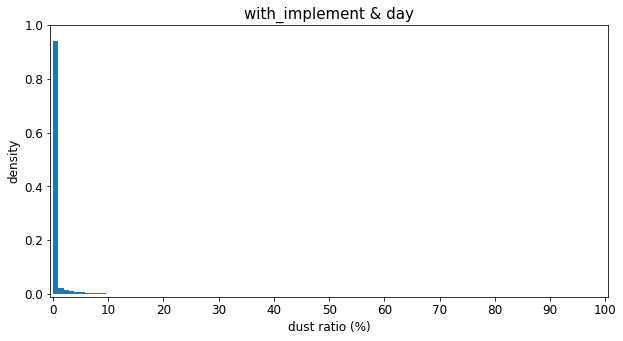

(990618, 95) dust ratio > 0.1 (18210, 95)
990618 0.0 96.27761840820312


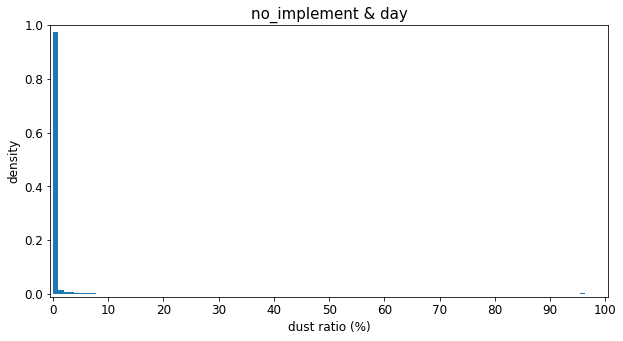

In [89]:
# plot_distribution(df[(~df.camera_location.str.startswith('front')) & (df.operation_time == 'dawn_dusk')], 'rear-pod dawn_dusk')
# plot_distribution(df[df.operation_time == 'nightime'], 'night')
# plot_distribution(df[df.state == 'Texas'], 'Texas')
# plot_distribution(df[(pd.DatetimeIndex(df.datetime).month > 1) & (pd.DatetimeIndex(df.datetime).month < 5)], 'Sring')
# plot_distribution(df[(pd.DatetimeIndex(df.datetime).month > 4) & (pd.DatetimeIndex(df.datetime).month < 8)], 'Summer')
# plot_distribution(df[(pd.DatetimeIndex(df.datetime).month > 7) & (pd.DatetimeIndex(df.datetime).month < 11)], 'Fall')
# plot_distribution(df[(pd.DatetimeIndex(df.datetime).month > 10) | (pd.DatetimeIndex(df.datetime).month < 2)], 'Winter')

plot_distribution(dfimp[(dfimp.operation_time == 'daytime') & (dfimp.implement_type != 'unknown')], 'with_implement & day')
plot_distribution(dfimp[(dfimp.operation_time == 'daytime') & (dfimp.implement_type == 'unknown')], 'no_implement & day')


In [ ]:
plot_distribution(df[(df.operation_time == 'daytime') & (df.speed_mph > 3) & (df.speed_mph < 8)], '3 < mph < 8 & day')

## Detailed statistics

In [ ]:
# count dusty days
states = df.state.unique()
operation_times = df.operation_time.unique()
day_d = {s: {ot: [0, 0] for ot in operation_times} for s in states}
for s in states:
    for ot in operation_times:
        _df = df[(df.state == s) & (df.operation_time == ot)]
        g = _df.groupby(['robot_name', 'date'])
    
        if ot == 'daytime':
            dust_threshold = 0.05
        else:
            dust_threshold = 0.15
        cnt = 0
        for r, d in g.groups.keys():
            __df = _df[(_df.robot_name == r) & (_df.date == d)]

            if (__df.dust_ratio > dust_threshold).any():
                cnt += 1
        day_d[s][ot][0] = cnt
        day_d[s][ot][1] = len(g.groups.keys())
day_d

In [ ]:
# count dusty hours
states = df.state.unique()
operation_times = df.operation_time.unique()
hour_d = {s: {ot: [0, 0] for ot in operation_times} for s in states}
for s in states:
    for ot in operation_times:
        _df = df[(df.state == s) & (df.operation_time == ot)]
        g = _df.groupby(['robot_name', 'date'])

        if ot == 'daytime':
            dust_threshold = 0.05
        else:
            dust_threshold = 0.15
        d_cnt, t_cnt = 0, 0
        for r, d in g.groups.keys():
            __df = _df[(_df.robot_name == r) & (_df.date == d)]
            for h in range(0, 24):
                ___df = __df[(pd.DatetimeIndex(__df.datetime).hour == h)]
                if ___df.shape[0] > 0:
                    t_cnt += 1
                    if ___df[(___df.dust_ratio > dust_threshold)].shape[0] >= 4:
                        d_cnt += 1
        hour_d[s][ot][0] = d_cnt  # dust occurrence
        hour_d[s][ot][1] = t_cnt  # total hours
hour_d

## Plot data on map

In [15]:
from mpl_toolkits.basemap import Basemap

In [16]:
sub_df = df[(df.operation_time == 'daytime')]
# sub_df = df[(df.state == 'Louisiana') & (df.operation_time == 'daytime')]
sub_df.shape

(1229469, 86)

In [17]:
sub_df = sub_df[sub_df.dust_ratio > 0.1]
sub_df.shape

In [18]:
sub_df.latitude.min(), sub_df.latitude.max()

(31.3366504, 43.24570229999999)

In [19]:
sub_df.longitude.min(), sub_df.longitude.max()

(-119.5976644, -83.93815000000001)

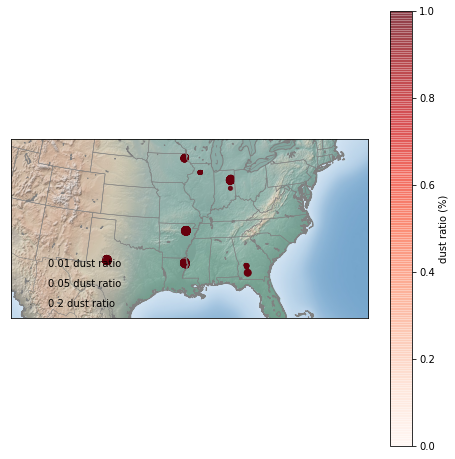

In [21]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=sub_df.latitude.mean(), lon_0=sub_df.longitude.mean(),
            width=4e6, height=2e6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(sub_df.longitude, sub_df.latitude, latlon=True,
          c=np.ones(sub_df.shape[0]), s=sub_df.dust_ratio*100,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'dust ratio (%)')
plt.clim(0.0, 1.0)

# make legend with dummy points
for a in [0.01, 0.05, 0.2]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' dust ratio')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

### Aggregate by geolocation

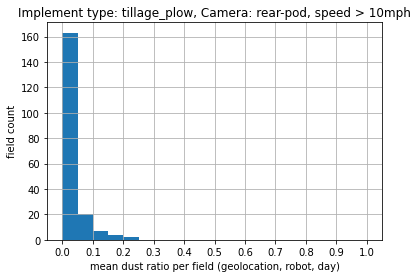

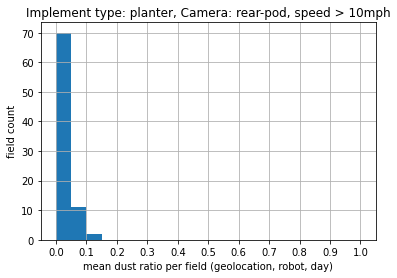

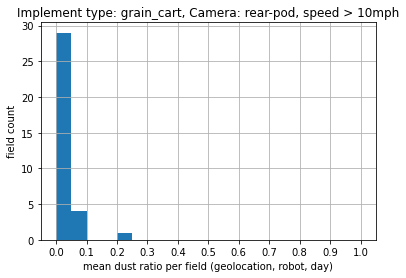

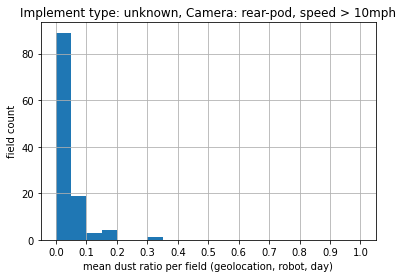

In [27]:
for implement_type in ['tillage_plow', 'planter', 'grain_cart', 'unknown']:
    grouped = day_df[(day_df.implement_type == implement_type) & (day_df.speed_mph > 10) & (~day_df.camera_location.str.startswith('front'))].groupby(['short_geohash_6', 'robot_name', 'date'])
    mean = grouped.mean()
    plt.title(f'Implement type: {implement_type}, Camera: rear-pod, speed > 10mph')
    mean['dust_ratio'].hist(range=[0,1], bins=20)
    plt.xticks(np.arange(0.0,1.1,0.1))
    plt.xlabel('mean dust ratio per field (geolocation, robot, day)')
    plt.ylabel('field count')
    plt.show()

### Dust frequency

In [90]:
# day_df['dusty'] = day_df.dust_ratio > 0.1

for implement_type in ['tillage_plow', 'planter', 'grain_cart', 'unknown']:
    sub_df = day_df[(day_df.implement_type == implement_type)]
    bags = sub_df.bag_name.unique()
    freq = [len(sub_df[(sub_df.bag_name == bag) & (sub_df.dust_ratio > 0.1)]) / len(sub_df[sub_df.bag_name == bag]) for bag in bags if len(sub_df[sub_df.bag_name == bag]) > 10]
    plt.hist(freq)
    plt.title(f'Implement type: {implement_type}')
    plt.xticks(np.arange(0.0,1.1,0.1))
    plt.xlabel('>10% dust frequency')
    plt.ylabel('counts of bags')
    plt.show()
#     break

KeyboardInterrupt: 

## Plot bar chart

In [ ]:
def plot_bar_chart(x, y, title, xlabel, ylabel='count'):
    plt.figure(1, figsize=(10, 5))
    plt.bar(x, y)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()

In [ ]:
sub_df = dfimp[(dfimp.operation_time == 'daytime')]
x = ['tillage_plow', 'planter', 'grain_cart', 'unknown']
y = [len(sub_df[(sub_df.implement_type == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / len(sub_df[sub_df.implement_type == i]) for i in x]
plt.bar(x, y)
plt.title('10-20% dust level probability at day', fontsize=15)
plt.xlabel('implement type', fontsize=12)
plt.ylabel('probability within the implement type', fontsize=12)
plt.show()

sub_df = dfimp[(dfimp.operation_time == 'daytime')]
x = ['tillage_plow', 'planter', 'grain_cart', 'unknown']
y = [len(sub_df[(sub_df.implement_type == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio > 0.2)]) / len(sub_df[sub_df.implement_type == i]) for i in x]
plt.bar(x, y)
plt.title('>20% dust level probability at day', fontsize=15)
plt.xlabel('implement type', fontsize=12)
plt.ylabel('probability within the implement type', fontsize=12)
plt.show()

sub_df = dfimp[(dfimp.operation_time != 'daytime')]
x = ['tillage_plow', 'planter', 'grain_cart', 'unknown']
y = [len(sub_df[(sub_df.implement_type == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / len(sub_df[sub_df.implement_type == i]) for i in x]
plt.bar(x, y)
plt.title('10-20% dust level probability at night & dawn_dusk', fontsize=15)
plt.xlabel('implement type', fontsize=12)
plt.ylabel('probability within the implement type', fontsize=12)
plt.show()

sub_df = dfimp[(dfimp.operation_time != 'daytime')]
x = ['tillage_plow', 'planter', 'grain_cart', 'unknown']
y = [len(sub_df[(sub_df.implement_type == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio > 0.2)]) / len(sub_df[sub_df.implement_type == i]) for i in x]
plt.bar(x, y)
plt.title('>20% dust level probability at night & dawn_dusk', fontsize=15)
plt.xlabel('implement type', fontsize=12)
plt.ylabel('probability within the implement type', fontsize=12)
plt.show()

In [ ]:
x = ['Arkansas', 'California', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Louisiana', 'Texas']
xlabel = 'state'
ylabel = 'probability within the state'

sub_df = df[(df.operation_time == 'daytime')]
y = [len(sub_df[(sub_df.state == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / len(sub_df[sub_df.state == i]) for i in x]
title = f'10-20% dust level probability in different states at day'
plot_bar_chart(x, y, title, xlabel, ylabel)

sub_df = df[(df.operation_time == 'daytime')]
y = [len(sub_df[(sub_df.state == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio > 0.2)]) / len(sub_df[sub_df.state == i]) for i in x]
title = f'>20% dust level probability in different states at day'
plot_bar_chart(x, y, title, xlabel, ylabel)

sub_df = df[(df.operation_time != 'daytime')]
y = [len(sub_df[(sub_df.state == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / len(sub_df[sub_df.state == i]) for i in x]
title = f'10-20% dust level probability in different states at night & dawn_dusk'
plot_bar_chart(x, y, title, xlabel, ylabel)

sub_df = df[(df.operation_time != 'daytime')]
y = [len(sub_df[(sub_df.state == i) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio > 0.2)]) / len(sub_df[sub_df.state == i]) for i in x]
title = f'>20% dust level probability in different states at night & dawn_dusk'
plot_bar_chart(x, y, title, xlabel, ylabel)

## Plot bar chart as broken down by job and camera
 - note each plot contains two sets of bars: blue bar stands for image count and green bar stands for percentage

In [32]:
def plot_bar_chart(x, y, y2, title, xlabel, ylabel, ylabel2):
    fig = plt.figure(1, figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    ax.bar(x, y, width=-0.4, align='edge', color='b')
    ax2.bar(x, y2, width=0.4, align='edge', color='g')
    plt.title(title, fontsize=15)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax2.set_ylabel(ylabel2, fontsize=12)
    plt.show()

In [33]:
# jobs = ['tillage_plow', 'planter', 'grain_cart', 'no_implement']
jobs = ['tillage_plow', 'planter', 'grain_cart', 'unknown']
# cameras = ['front-left-left', 'front-center-left', 'front-right-left', 'side-left-left', 'rear-left', 'side-right-left']
cameras = ['front-pod', 'rear-pod']

### DE Regions

In [30]:
region_map = {'Arkansas':'Arkansas', 'California':'Division A', 'Wyoming':'Division A', 'Georgia':'Georgia', 
              'Illinois':'Illinois', 'Alabama':'Division D', 'Nebraska': 'Division B',
              'Indiana':'Indiana', 'Iowa':'Division B', 'Louisiana':'Division D', 'Texas':'Division D'}
day_df['region'] = day_df['state'].apply(lambda x: region_map[x])

/tmp/ipykernel_77565/3396786374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['region'] = day_df['state'].apply(lambda x: region_map[x])


tillage_plow front-pod # images 10334


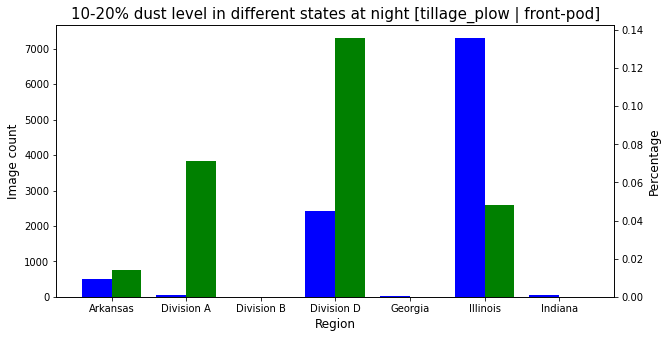

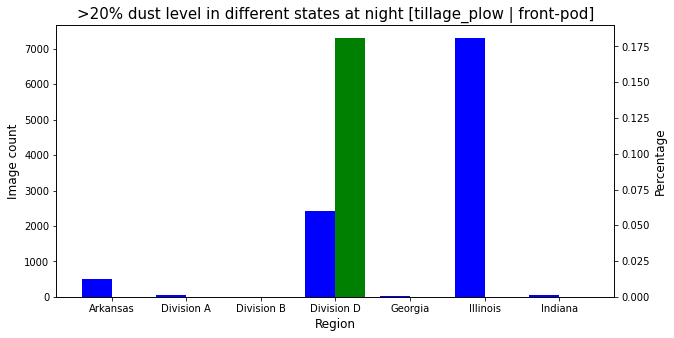

tillage_plow rear-pod # images 34527


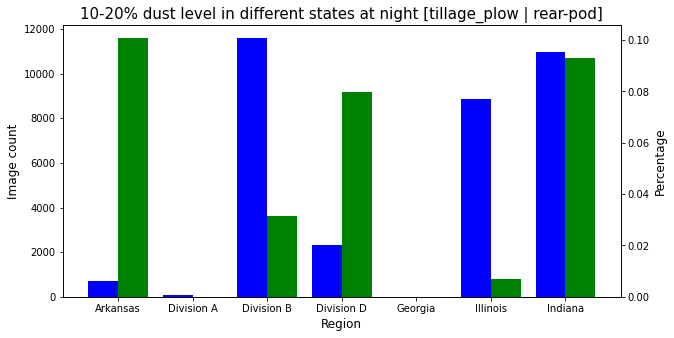

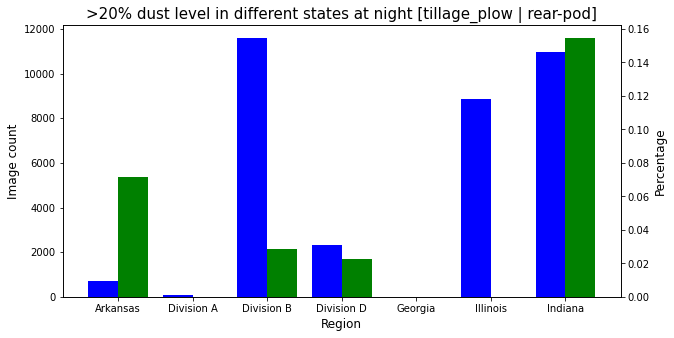

planter front-pod # images 11258


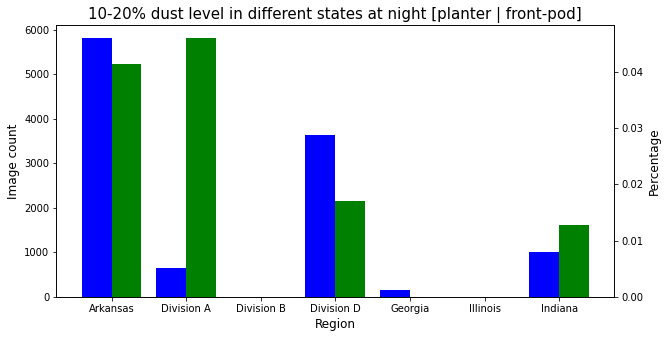

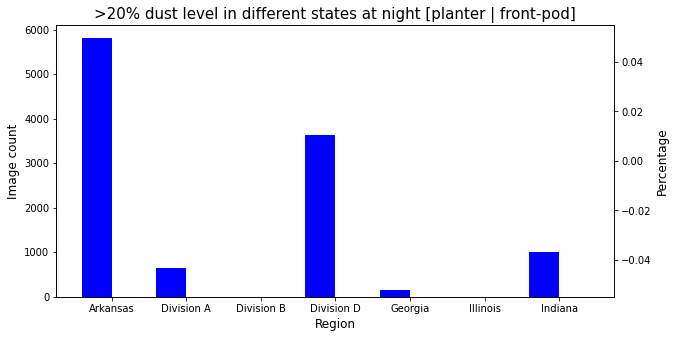

planter rear-pod # images 11182


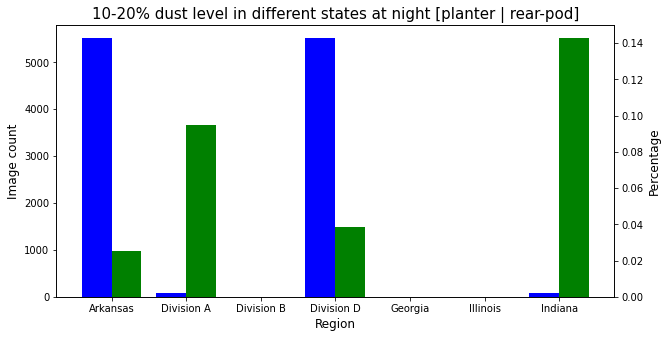

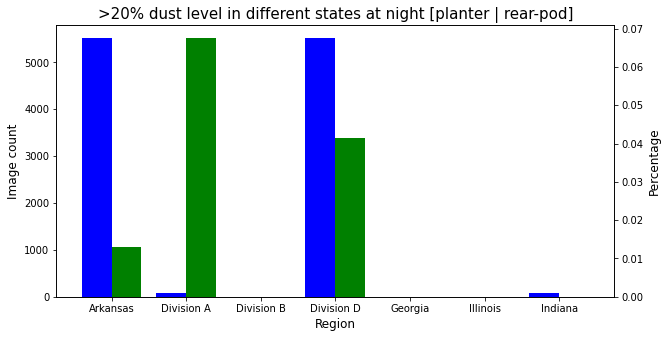

grain_cart front-pod # images 7825


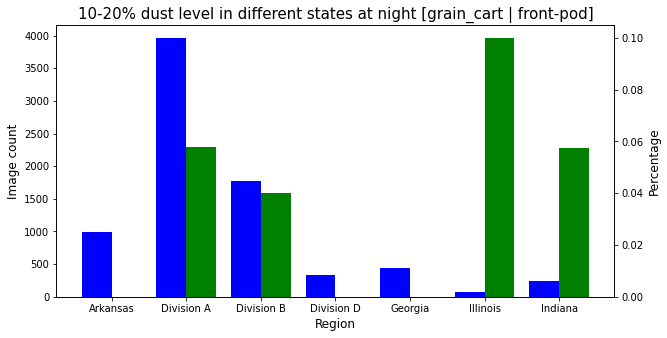

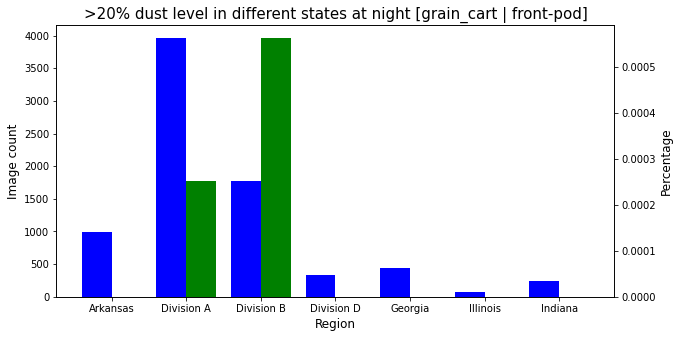

grain_cart rear-pod # images 7584


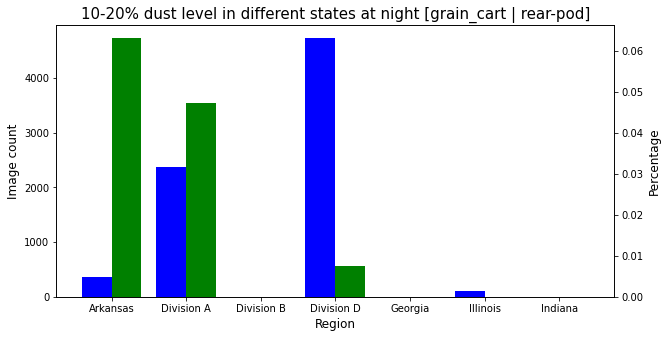

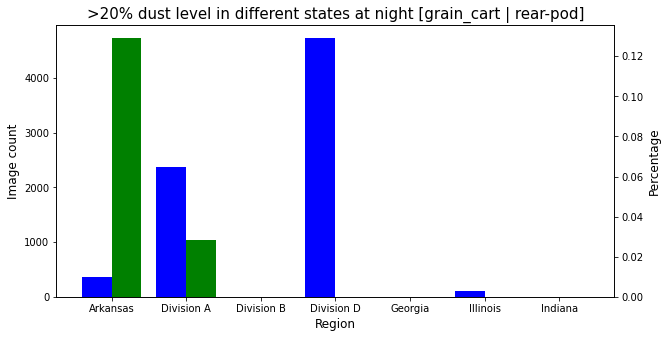

unknown front-pod # images 97379


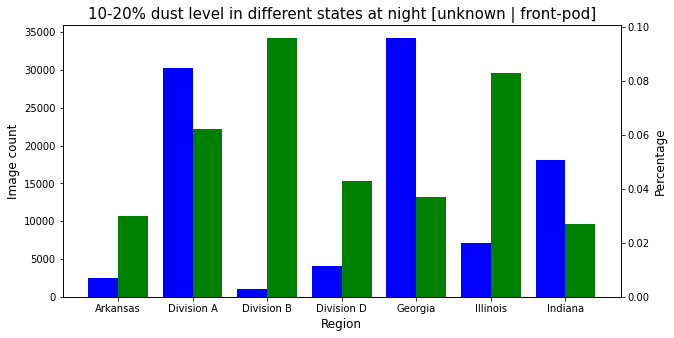

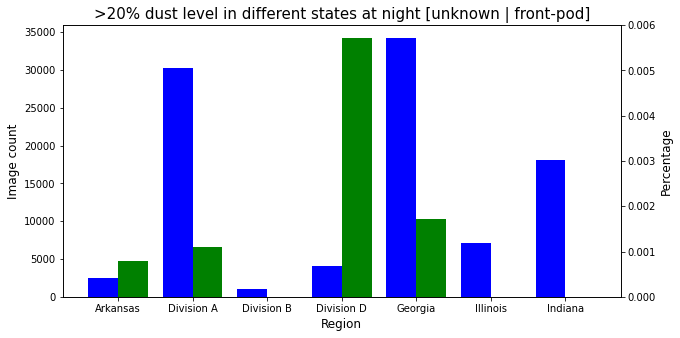

unknown rear-pod # images 10212


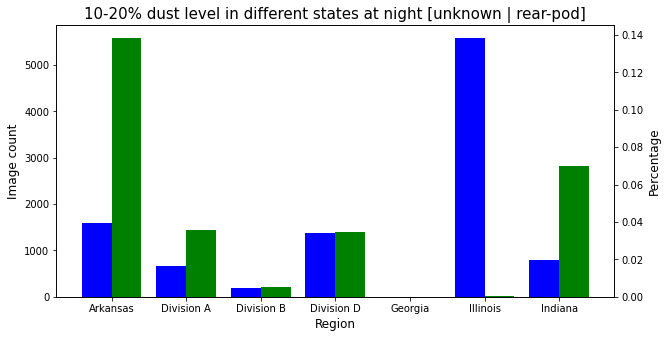

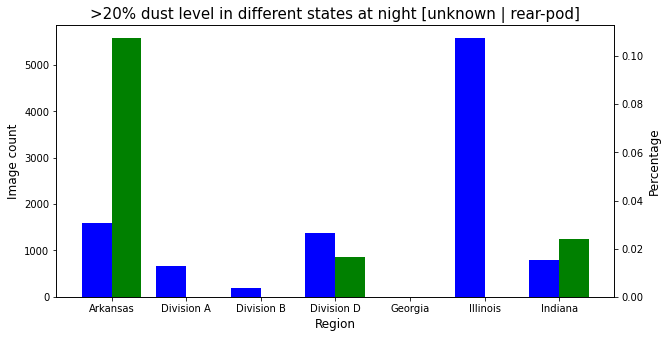

In [38]:
x = list(region_map.values())
x.sort()
xlabel = 'Region'
ylabel = 'Image count'
ylabel2 = 'Percentage'

for job in jobs:
    for camera in cameras:
        if camera == 'front-pod':
            sub_df = day_df[(day_df.implement_type == job) & (day_df.camera_location.str.startswith('front'))]
        else:
            sub_df = day_df[(day_df.implement_type == job) & (~day_df.camera_location.str.startswith('front'))]
        print(job, camera, '# images', len(sub_df))
        
        title = f'10-20% dust level in different states at {optime} [{job} | {camera}]'
        y = [len(sub_df[sub_df.region == s]) for s in x]
        y2 = [len(sub_df[(sub_df.region == s) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / (n if n > 0 else 1e8) for s, n in zip(x, y)]
        plot_bar_chart(x, y, y2, title, xlabel, ylabel, ylabel2)
        
        title = f'>20% dust level in different states at {optime} [{job} | {camera}]'
        y = [len(sub_df[sub_df.region == s]) for s in x]
        y2 = [len(sub_df[(sub_df.region == s) & (sub_df.dust_ratio > 0.2)]) / (n if n > 0 else 1e8) for s, n in zip(x, y)]
        plot_bar_chart(x, y, y2, title, xlabel, ylabel, ylabel2)

### Geolocation

tillage_plow front-pod # images 268


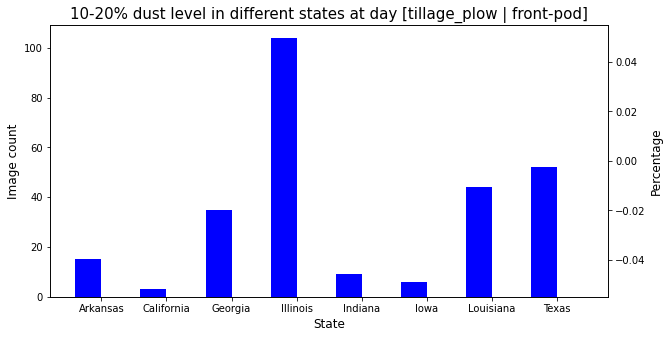

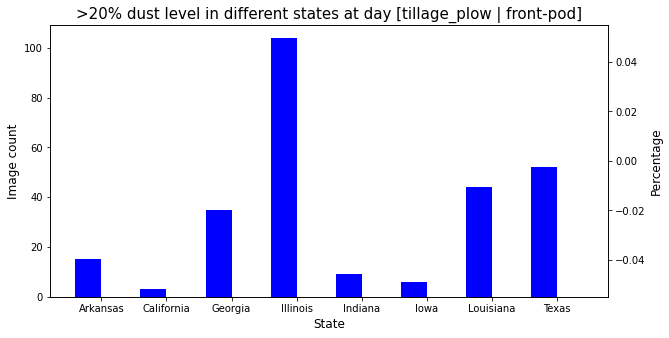

tillage_plow rear-pod # images 78305


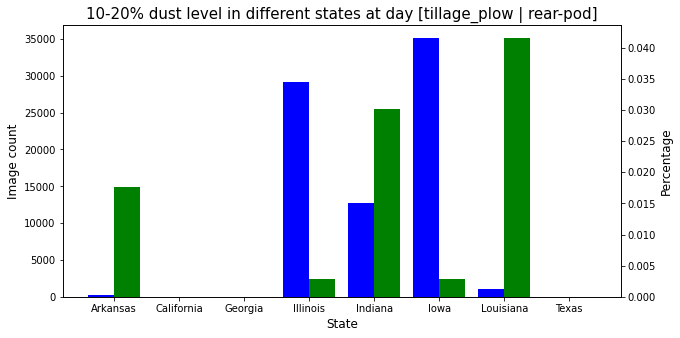

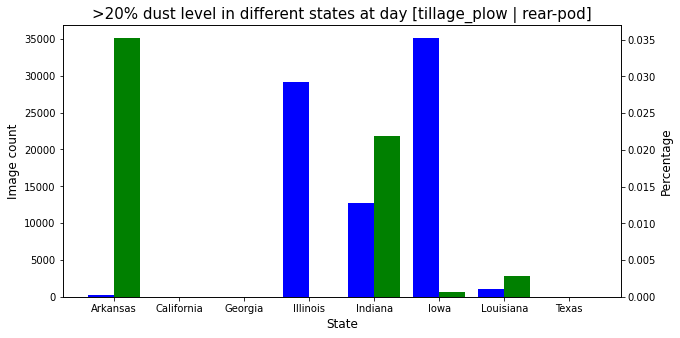

planter front-pod # images 237


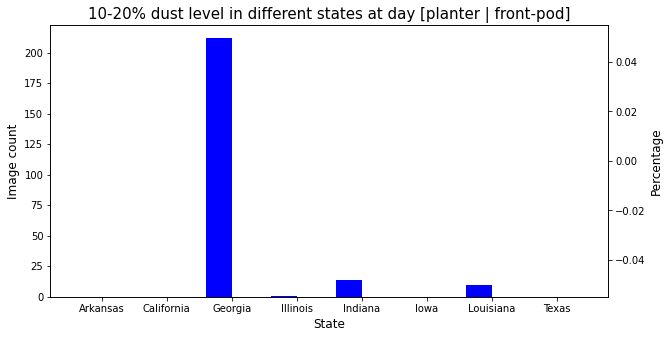

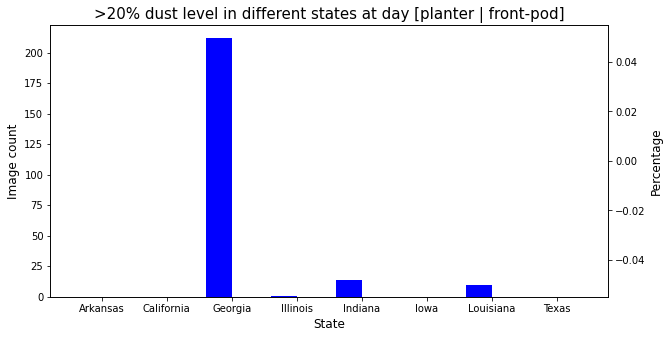

planter rear-pod # images 21936


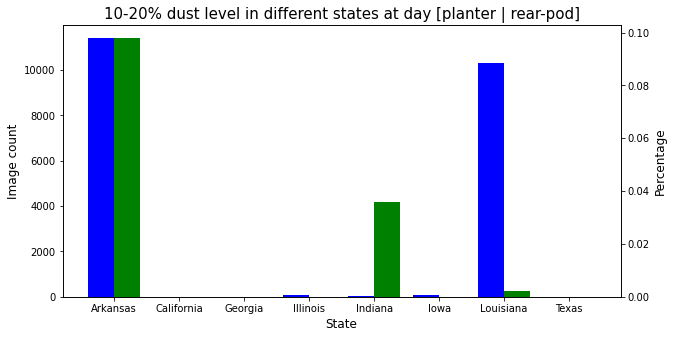

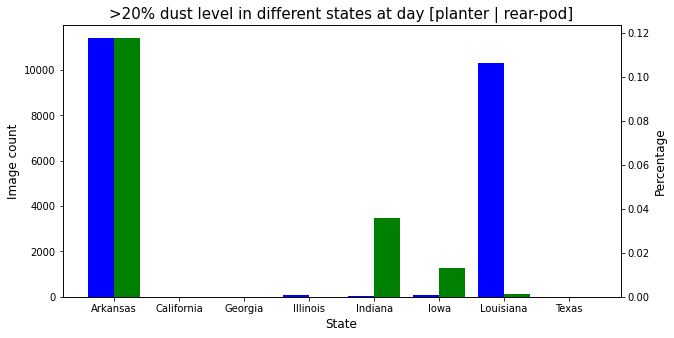

grain_cart front-pod # images 294


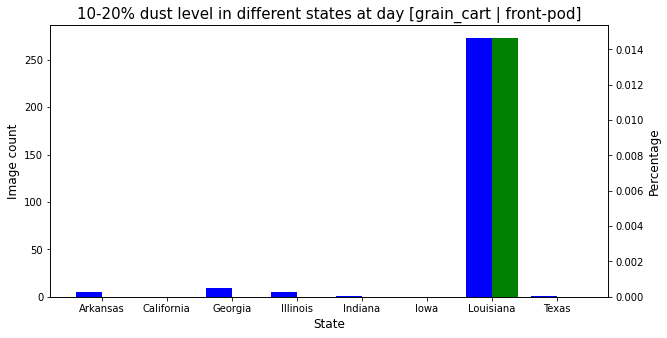

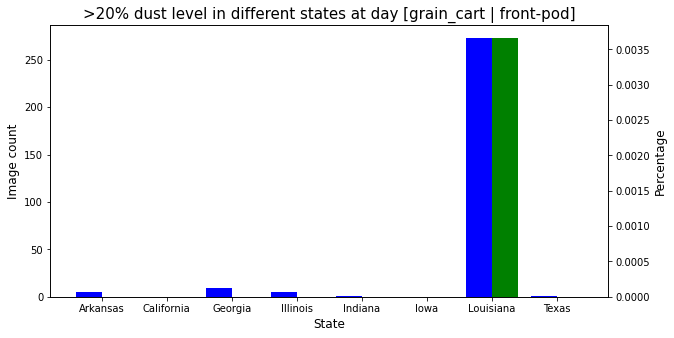

grain_cart rear-pod # images 5051


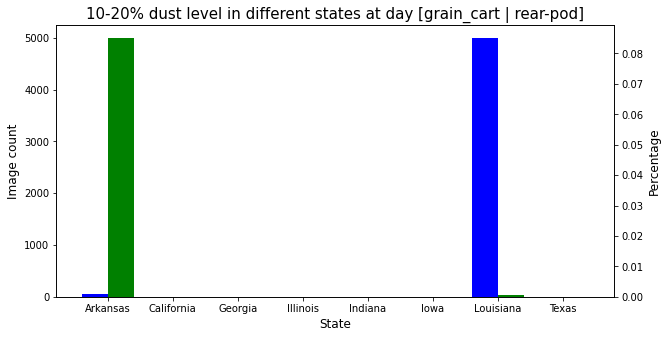

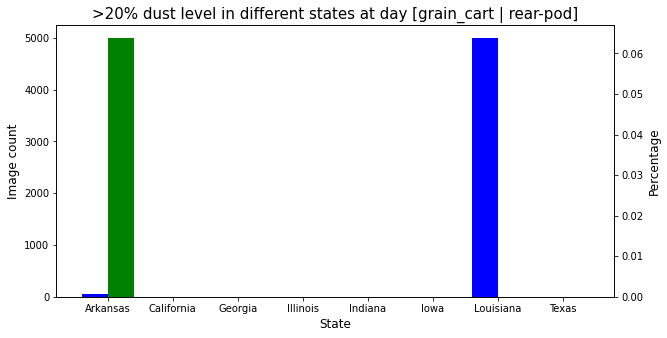

no_implement front-pod # images 203686


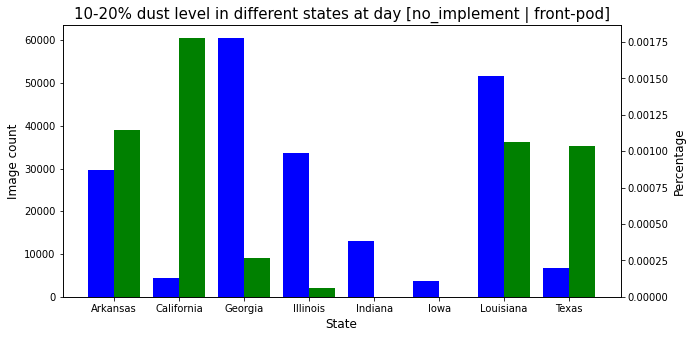

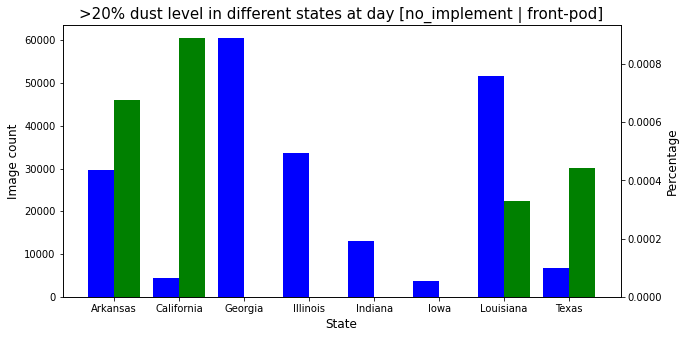

no_implement rear-pod # images 37209


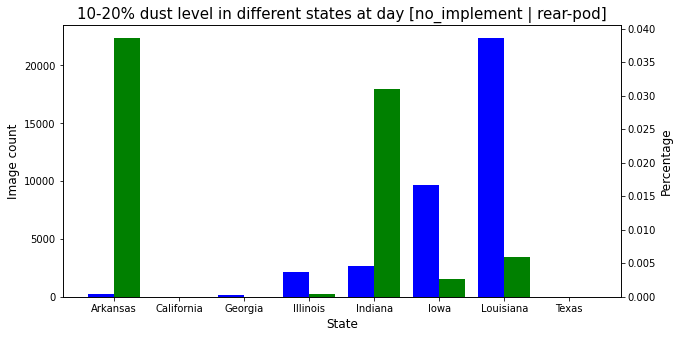

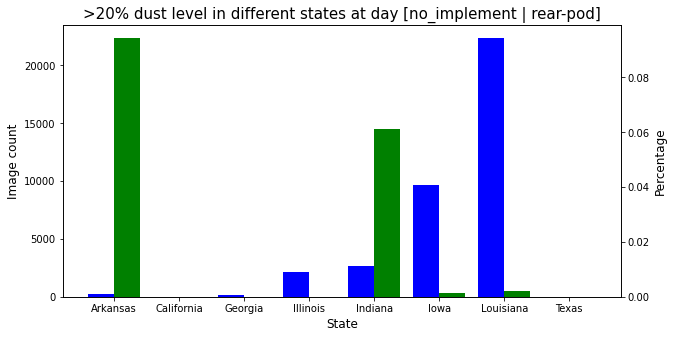

In [14]:
x = ['Arkansas', 'California', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Louisiana', 'Texas']
xlabel = 'State'
ylabel = 'Image count'
ylabel2 = 'Percentage'

for job in jobs:
    for camera in cameras:
        if camera == 'front-pod':
            sub_df = day_df[(day_df.implement_type == job) & (day_df.camera_location.str.startswith('front'))]
        else:
            sub_df = day_df[(day_df.implement_type == job) & (~day_df.camera_location.str.startswith('front'))]
        print(job, camera, '# images', len(sub_df))
        
        title = f'10-20% dust level in different states at {optime} [{job} | {camera}]'
        y = [len(sub_df[sub_df.state == s]) for s in x]
        y2 = [len(sub_df[(sub_df.state == s) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / (n if n > 0 else 1e8) for s, n in zip(x, y)]
        plot_bar_chart(x, y, y2, title, xlabel, ylabel, ylabel2)
        
        title = f'>20% dust level in different states at {optime} [{job} | {camera}]'
        y = [len(sub_df[sub_df.state == s]) for s in x]
        y2 = [len(sub_df[(sub_df.state == s) & (sub_df.dust_ratio > 0.2)]) / (n if n > 0 else 1e8) for s, n in zip(x, y)]
        plot_bar_chart(x, y, y2, title, xlabel, ylabel, ylabel2)

### Vehicle Speed

tillage_plow front-pod # images 10334


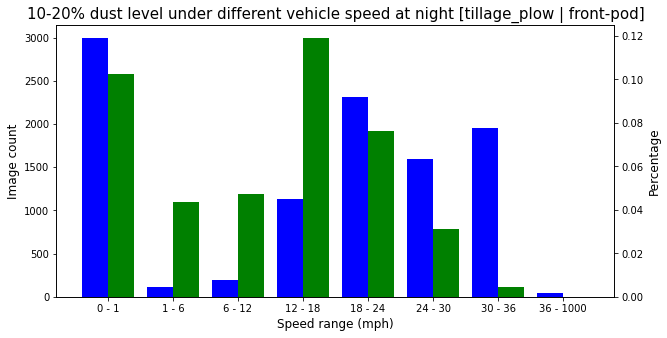

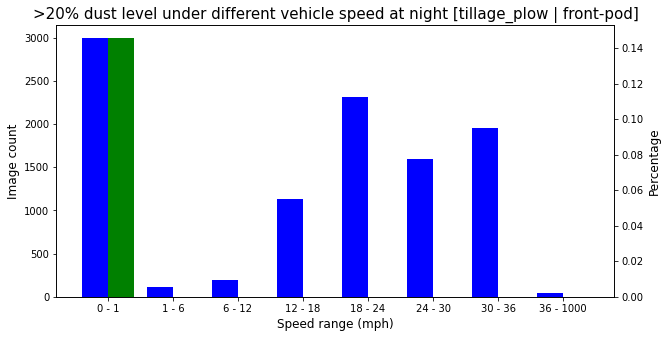

tillage_plow rear-pod # images 34527


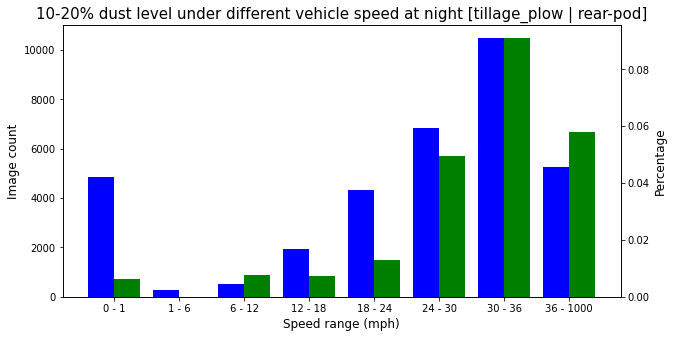

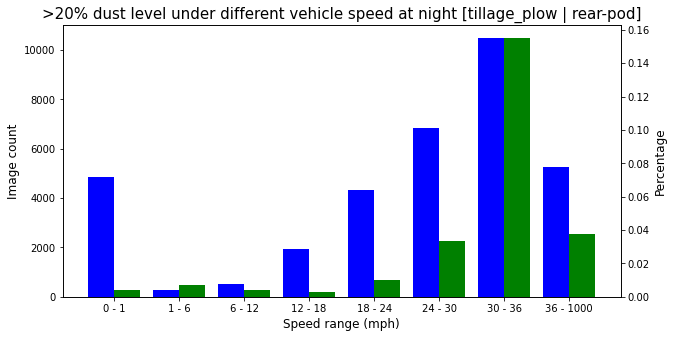

planter front-pod # images 11258


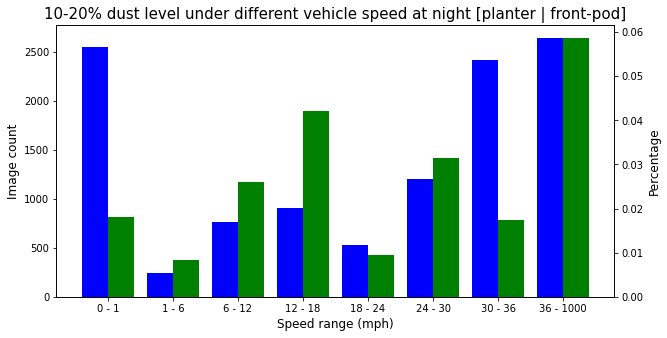

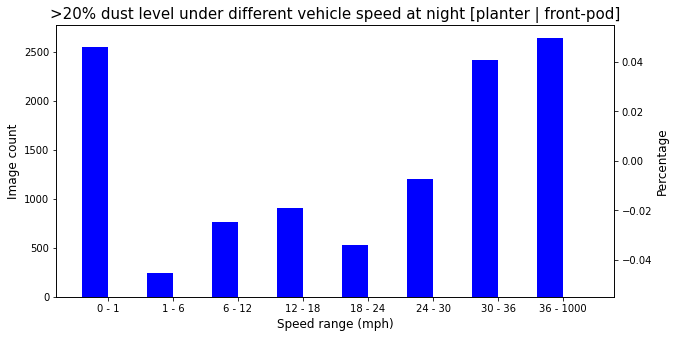

planter rear-pod # images 11182


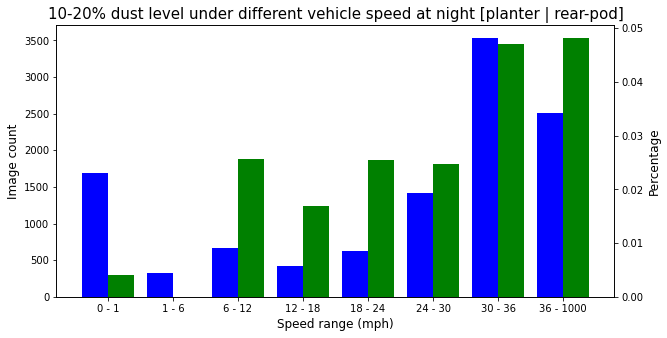

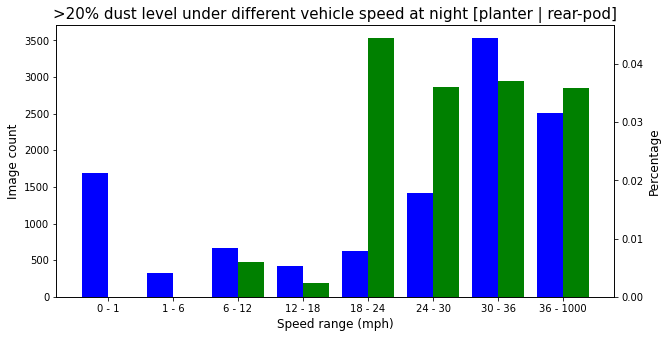

grain_cart front-pod # images 7825


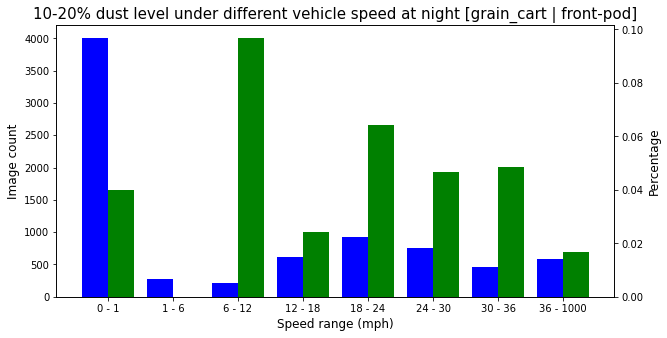

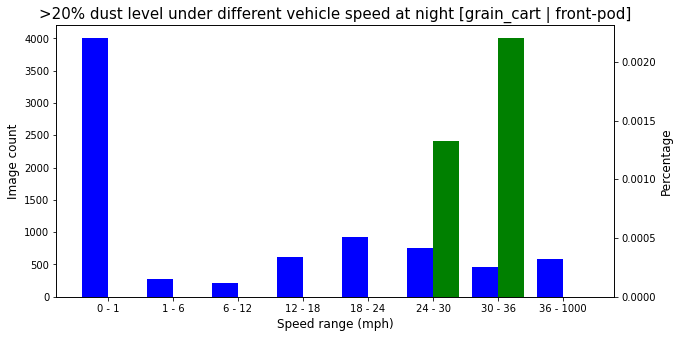

grain_cart rear-pod # images 7584


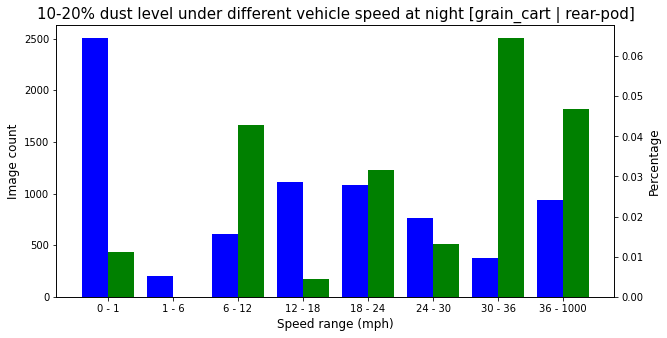

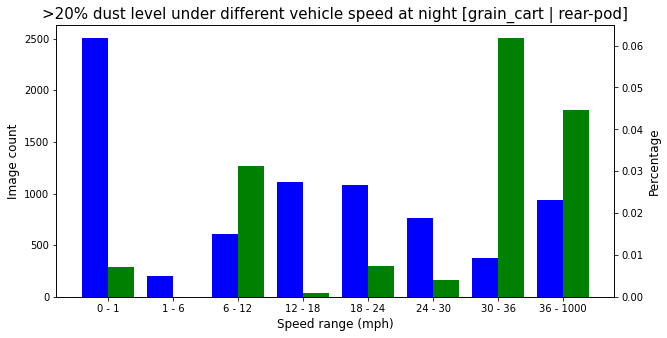

unknown front-pod # images 97379


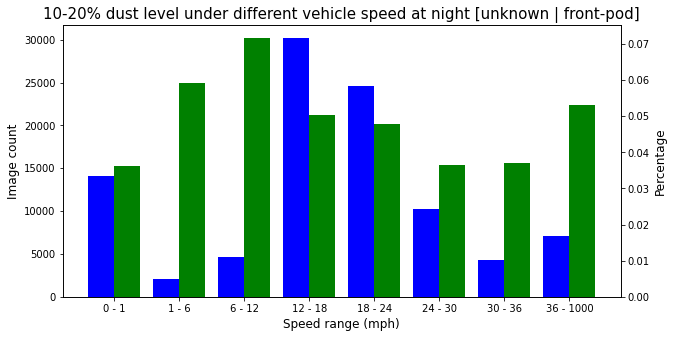

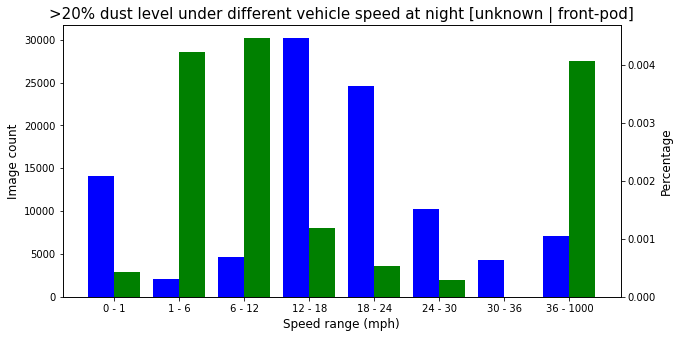

unknown rear-pod # images 10212


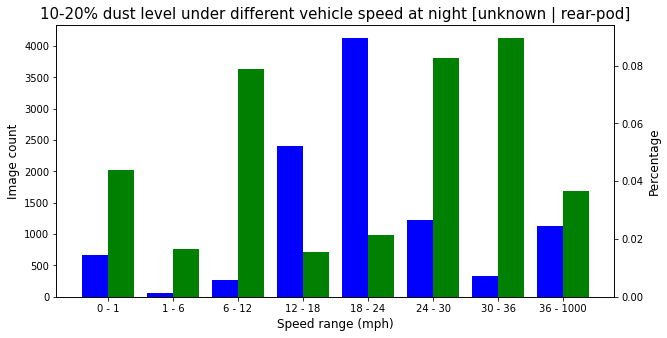

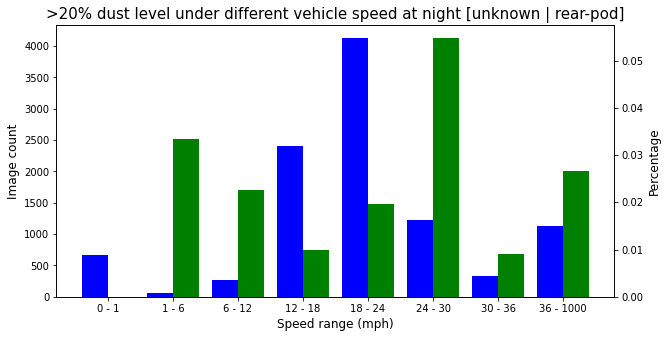

In [39]:
x = [[0, 1], [1, 6], [6, 12], [12, 18], [18, 24], [24, 30], [30, 36], [36, 1000]]
x_str = [f'{spd1} - {spd2}' for spd1,spd2 in x]
xlabel = 'Speed range (mph)'
ylabel = 'Image count'
ylabel2 = 'Percentage'

for job in jobs:
    for camera in cameras:
        if camera == 'front-pod':
            sub_df = day_df[(day_df.implement_type == job) & (day_df.camera_location.str.startswith('front'))]
        else:
            sub_df = day_df[(day_df.implement_type == job) & (~day_df.camera_location.str.startswith('front'))]
        print(job, camera, '# images', len(sub_df))
        
        title = f'10-20% dust level under different vehicle speed at {optime} [{job} | {camera}]'
        y = [len(sub_df[(sub_df.speed_mph >= spd1) & (sub_df.speed_mph < spd2)]) for spd1, spd2 in x]
        y2 = [len(sub_df[(sub_df.speed_mph >= spd1) & (sub_df.speed_mph < spd2) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / (n if n > 0 else 1e8) for (spd1,spd2), n in zip(x, y)]
        plot_bar_chart(x_str, y, y2, title, xlabel, ylabel, ylabel2)
        
        title = f'>20% dust level under different vehicle speed at {optime} [{job} | {camera}]'
        y = [len(sub_df[(sub_df.speed_mph >= spd1) & (sub_df.speed_mph < spd2)]) for spd1, spd2 in x]
        y2 = [len(sub_df[(sub_df.speed_mph >= spd1) & (sub_df.speed_mph < spd2) & (sub_df.dust_ratio > 0.2)]) / (n if n > 0 else 1e8) for (spd1,spd2), n in zip(x, y)]
        plot_bar_chart(x_str, y, y2, title, xlabel, ylabel, ylabel2)

### Wind Speed

tillage_plow front-pod # images 10334


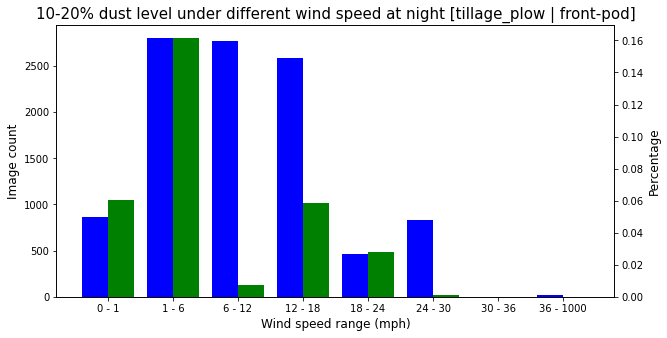

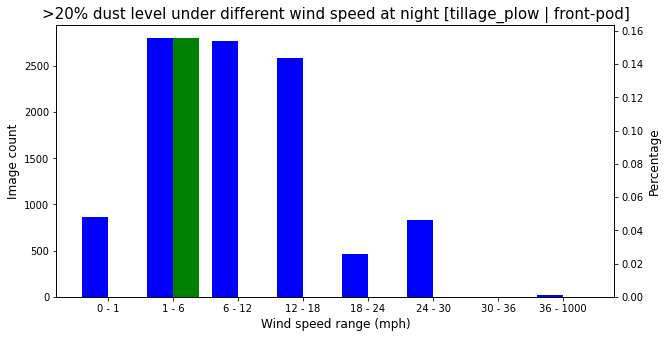

tillage_plow rear-pod # images 34527


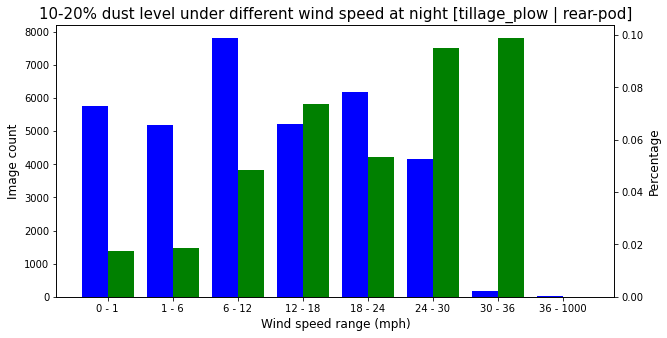

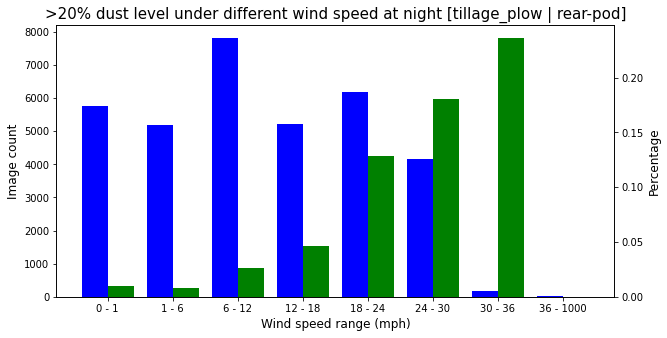

planter front-pod # images 11258


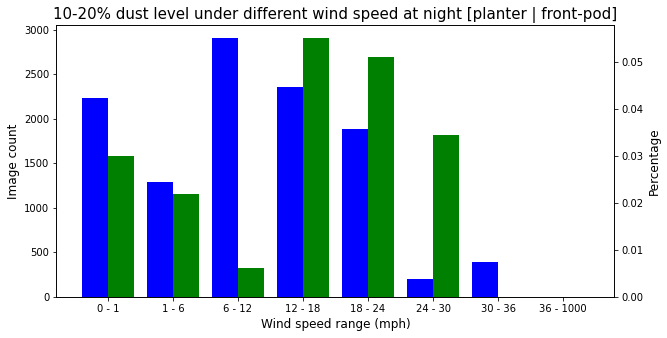

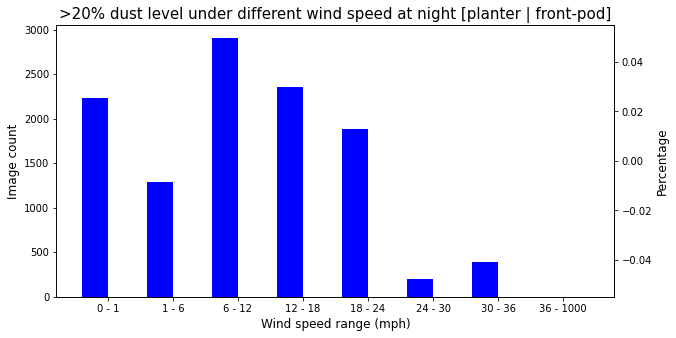

planter rear-pod # images 11182


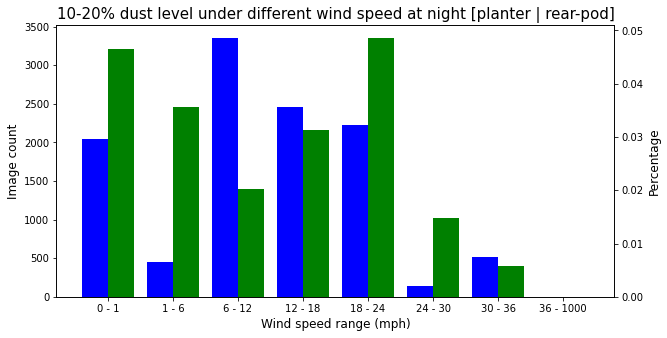

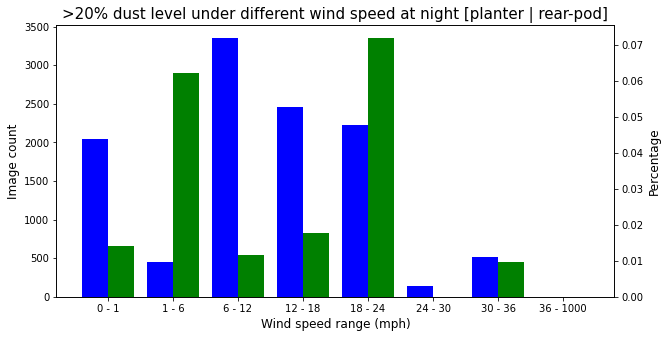

grain_cart front-pod # images 7825


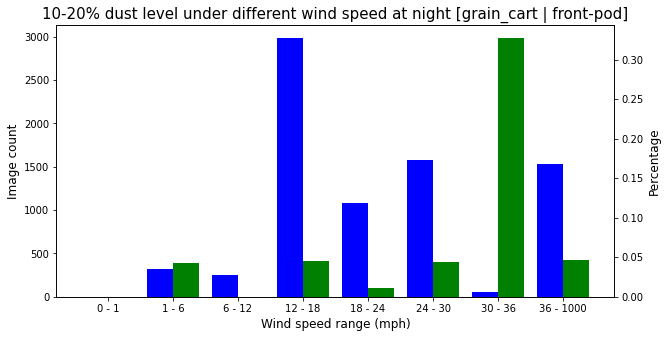

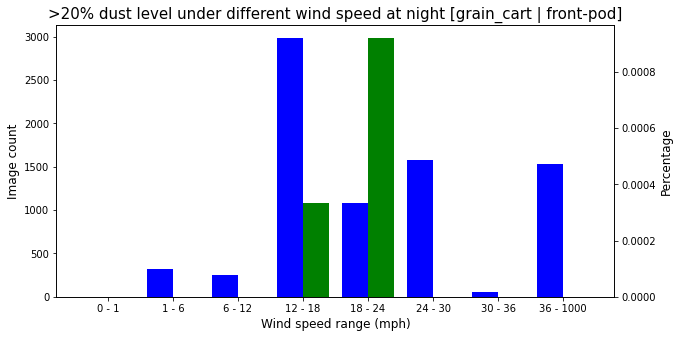

grain_cart rear-pod # images 7584


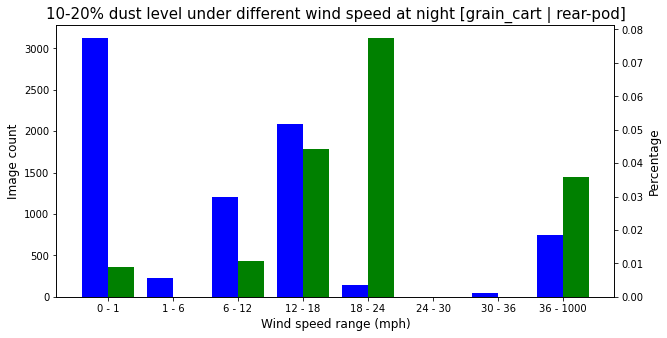

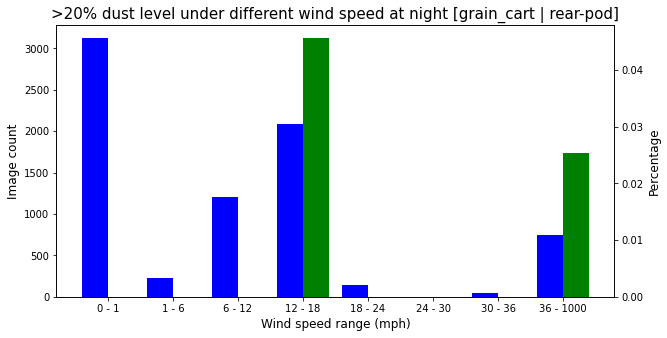

unknown front-pod # images 97379


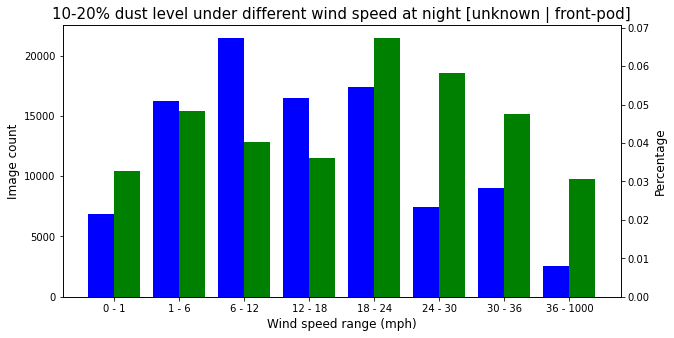

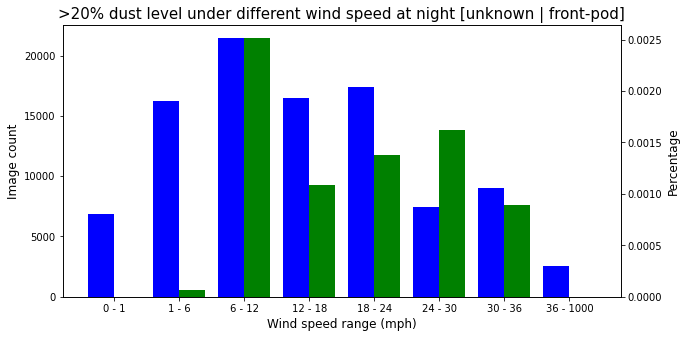

unknown rear-pod # images 10212


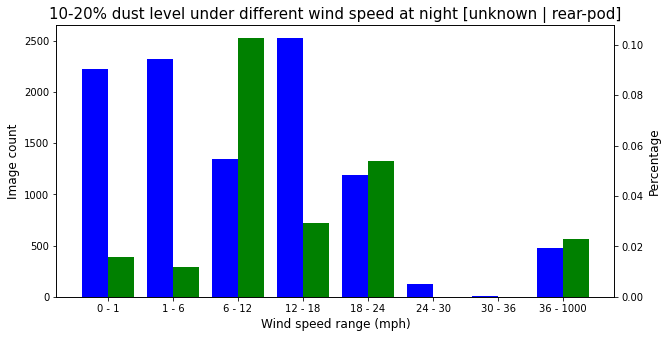

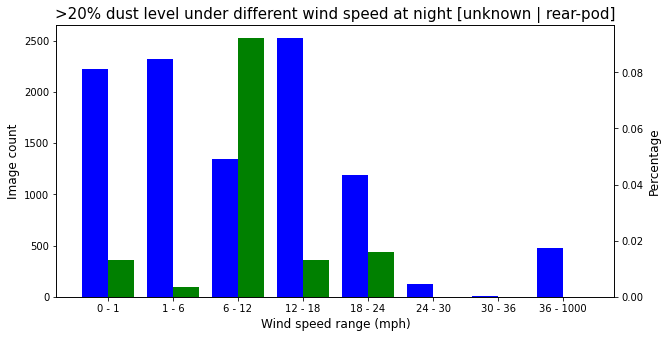

In [40]:
x = [[0, 1], [1, 6], [6, 12], [12, 18], [18, 24], [24, 30], [30, 36], [36, 1000]]
x_str = [f'{spd1} - {spd2}' for spd1,spd2 in x]
xlabel = 'Wind speed range (mph)'
ylabel = 'Image count'
ylabel2 = 'Percentage'

for job in jobs:
    for camera in cameras:
        if camera == 'front-pod':
            sub_df = day_df[(day_df.implement_type == job) & (day_df.camera_location.str.startswith('front'))]
        else:
            sub_df = day_df[(day_df.implement_type == job) & (~day_df.camera_location.str.startswith('front'))]
        print(job, camera, '# images', len(sub_df))
        
        title = f'10-20% dust level under different wind speed at {optime} [{job} | {camera}]'
        y = [len(sub_df[(sub_df.wind_speed_mph >= spd1) & (sub_df.wind_speed_mph < spd2)]) for spd1, spd2 in x]
        y2 = [len(sub_df[(sub_df.wind_speed_mph >= spd1) & (sub_df.wind_speed_mph < spd2) & (sub_df.dust_ratio > 0.1) & (sub_df.dust_ratio < 0.2)]) / (n if n > 0 else 1e8) for (spd1,spd2), n in zip(x, y)]
        plot_bar_chart(x_str, y, y2, title, xlabel, ylabel, ylabel2)
        
        title = f'>20% dust level under different wind speed at {optime} [{job} | {camera}]'
        y = [len(sub_df[(sub_df.wind_speed_mph >= spd1) & (sub_df.wind_speed_mph < spd2)]) for spd1, spd2 in x]
        y2 = [len(sub_df[(sub_df.wind_speed_mph >= spd1) & (sub_df.wind_speed_mph < spd2) & (sub_df.dust_ratio > 0.2)]) / (n if n > 0 else 1e8) for (spd1,spd2), n in zip(x, y)]
        plot_bar_chart(x_str, y, y2, title, xlabel, ylabel, ylabel2)